### 観測データ
解析に必要なデータ
- XFFTS data
- encoder (doppler計算できない)
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking[x]
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

In [10]:
!ls /home/amigos/data/position_switching2019/n20190831094711_12CO_2-1_otf_OriKL/
import time
start_time = time.time()

hosei_230.txt  ps_OriKL.obs  weather.csv  xffts.ndf


In [57]:
#radec 変換データ作成
#! python analy_coordinates.py
import sys
sys.path.append("../script/")
import subprocess
import os
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
import glob
###以下独自
import n2df
import read_obsfile
import analy_doppler_nanten

In [65]:
analy_dir = "/home/amigos/data/position_switching2019/n20190831094711_12CO_2-1_otf_OriKL/"
analy_dir = "/home/amigos/data/position_switching2019/n20190904073619_12CO_2-1_otf_OriKL/" # hosei parameters= 0
subprocess.getoutput(["ls {}".format(analy_dir)]).split("\n")
obspath = glob.glob(analy_dir+"/*obs")
obs = read_obsfile.read(obspath[0])

In [15]:
import log_weather
import numpy
###気象情報の読み込み
weather_data = log_weather.Weather_log(os.path.join(analy_dir, "weather.csv")).read()
print(weather_data)
#気象データの確認
press = numpy.mean(weather_data["press"])
humi = numpy.mean(weather_data["outhumi"])
temp = numpy.mean(weather_data["outtemp"])
lamda = 1300
print(press, humi, temp)

cabin_temp = weather_data["cabin_temp1"]

      timestamp     intemp    outtemp    inhumi   outhumi     winddir  \
0  1.567583e+09  14.956652  15.911570  1.751314  8.712573  268.297682   
1  1.567583e+09  14.661236  15.885827  1.252074  8.030655  268.750100   
2  1.567583e+09  14.466728  16.327802  1.903607  8.747741  268.233242   
3  1.567583e+09  15.007114  16.614927  1.582627  8.367952  268.563059   
4  1.567583e+09  14.577122  16.337344  1.702686  8.648920  268.249792   

     windsp       press      rain  cabin_temp1  cabin_temp2  dome_temp1  \
0  6.752982  570.395694  0.619969    21.440811    32.531285   10.670156   
1  6.184196  570.725141  0.223604    22.112163    32.064726   10.264792   
2  6.586468  570.637256  0.969153    21.818540    32.567815   10.650784   
3  6.184204  570.701967  0.321139    22.113329    31.744670   10.596939   
4  5.956937  570.278695  0.898055    22.173852    32.571921   10.245508   

   dome_temp2  gen_temp1  gen_temp2  scan_num  obs_mode  
0   13.517497  10.332148  13.314338         0       

In [16]:
array_num = 2#1~16IF 

### 分光データの読み出し


In [116]:
%%time
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた
timestamp = n.read_timestamp()

100%|██████████| 1113/1113 [00:00<00:00, 349446.84it/s]

CPU times: user 40 ms, sys: 32 ms, total: 72 ms
Wall time: 95.8 ms


### Doppler tracking

In [117]:
on_x = obs["lambda_on"]
on_y = obs["beta_on"]
off_x = obs["lambda_off"]
off_y = obs["beta_off"]

In [118]:
#this will be added
from numpy import deg2rad
from scipy import interpolate

d = analy_doppler_nanten.doppler_nanten()
#vobs = [d.calc_vobs(deg2rad(xffts[0][i]),deg2rad(xffts[1][i]), xffts[2][i]) for i in tqdm(range(len(xffts[0])))]
vobs = []
# for i in range(len(array_data)):
#     if obs_mode[i] == "ON":
#         vobs.append(d.calc_vobs(deg2rad(on_x), deg2rad(on_y), timestamp[i]))
#     elif obs_mode[i] == "OFF" or obs_mode[i] == "HOT":
#         vobs.append(d.calc_vobs(deg2rad(off_x), deg2rad(off_y), timestamp[i]))      
# numpy.save(os.path.join(analy_dir, "vobs"), vobs)
vobs = numpy.load(os.path.join(analy_dir, "./vobs.npy"))

vobs = numpy.array(vobs)
if numpy.count_nonzero(vobs>0) == len(vobs):
    print("vobsは全て正")
elif numpy.count_nonzero(vobs<0) == len(vobs):
    print("vobsは全て負")
else:
    print("vobsは正も負もある")

#config
dv = 0.167#km/s
ch = numpy.linspace(0, 32767, 32768)
bch = list(map(int, vobs//dv))#ch数の移動
slide_ch = (vobs/dv) - bch#interpolationによる移動量
bch_max = numpy.max(bch)
bch_min = numpy.min(bch)

dp_data = []
xx_data = []
print(numpy.shape(array_data[1]))
for i in tqdm(range(len(vobs))):
    f = interpolate.interp1d(ch, array_data[i])
    ch2 = ch+slide_ch[i]
    if slide_ch[i] > 0:
        n = f(ch2[:-1])
    elif slide_ch[i] <0:
        n = f(ch2[1:])
    new_p = n
    if vobs[i] >0:
        xx = ch[:-1] - bch[i]
        #yy = new_p[bch[i]:]
        yy = new_p
    elif vobs[i]<0:
        xx = ch[:-1] - bch[i]
        yy = new_p
        #yy = new_p[:bch[i]]
    xx_data.append(xx)
    dp_data.append(yy)
    
xx_data = numpy.array(xx_data)
xx_min = numpy.max(xx_data.T[0])#regridの最小値
xx_max = numpy.min(xx_data.T[-1])#regirdの最大値

new_xx = numpy.arange(xx_min, xx_max+1, 1)

mask_list= []
for i in range(len(xx_data)):
    mask = (xx_data[i] >= xx_min) & (xx_data[i] <= xx_max)
    mask_list.append(mask)
    
new_yy_list = []
for i in tqdm(range(len(xx_data))):
    new_yy_list.append(dp_data[i][mask_list[i]])
origin_array_data = array_data
array_data = new_yy_list

len_array_data = len(array_data[0])

  3%|▎         | 35/1113 [00:00<00:03, 341.61it/s]

vobsは全て正
(32768,)


100%|██████████| 1113/1113 [00:00<00:00, 10746.63it/s]


In [100]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

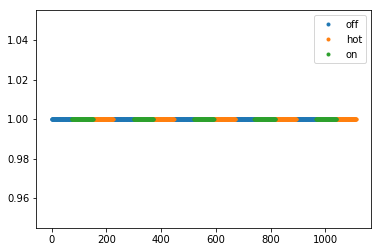

In [101]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
plt.legend()
plt.show()

[0 0 0 ... 5 5 5]


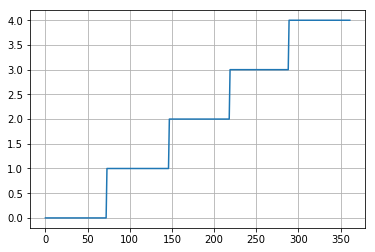

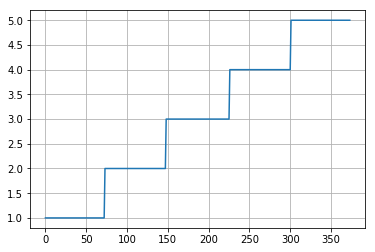

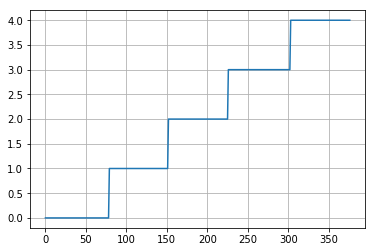

In [102]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON 点のscan number を取得
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/offの積分

In [103]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    #print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
hotdata = numpy.array(hotdata)
hotdata = hotdata + 5000

100%|██████████| 5/5 [00:00<00:00, 363.75it/s]

[1 2 3 4 5]


In [104]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))

100%|██████████| 5/5 [00:00<00:00, 351.55it/s]

[0 1 2 3 4]


In [105]:
##ONの積分
print(numpy.unique(scan_num[onindex[0]]))#HOT のscan number
on_num = numpy.unique(scan_num[onindex[0]])#HOTの数

ondata = []
scan_num = numpy.array(scan_num)

for i in tqdm(on_num):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], onindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    ondata.append(sum(tmp)/len(tmp))

100%|██████████| 5/5 [00:00<00:00, 349.64it/s]

[0 1 2 3 4]


Hot のデータはscan line分あるわけでないので補完
Off もscan line 分ある観測プログラムしかないはずだが、一応補完

補完の方法は次のOFF/HOTの点の観測を行うまでは直近のデータを採用する形

In [106]:
# ###Choper wheel
@numba.jit
def chopper_wheel(on, off, hot, temprature = 300):
    Tastar = (on - off)/(hot - off) * temprature
    return Tastar

In [107]:
chdata = [chopper_wheel(ondata[i], offdata[i], hotdata[i]) for i in range(len(ondata))]

## Baseline fitting

100%|██████████| 5/5 [00:00<00:00, 370.82it/s]

3000 7500 8500 30000


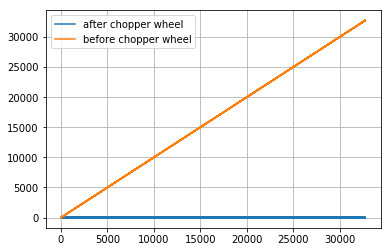

In [119]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, len_array_data, len_array_data)

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, len_array_data, len_array_data)

for i in tqdm(range(len(chdata))):
    chdata[i] = chdata[i] + testoffset#ベースラインフィッティングできているかの確認のため
    origin = chdata[i]#for debug, this will be deleted
    chdata[i] = baseline_fitting(chdata[i], xindex, index1, index2, index3, index4)
    
    
plt.plot(chdata[i], label="after chopper wheel")#after chopper wheel
plt.plot(origin, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

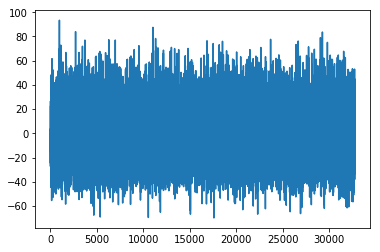

In [45]:
plt.plot(chdata[0])
plt.show()

### astropyでfitsに書き出す

ヘッダーの作成

In [120]:
# header_dict = {
# "object": obs["object"],
# "crval1": obs["lambda_on"],
# "cdelt1": obs["grid"]/3600,
# "crpix1": obs["N"]-1/2,#中心ピクセル
# "crval2": obs["beta_on"],
# "cdelt2": obs["grid"]/3600,
# "crpix2": obs["N"]-1/2, #中心ピクセル
# "cdelt3": 0.16,# km/s 
# "crval3": 0
# }

# temp = """
# SIMPLE  =                    T                                                  
# BITPIX  =                  -32                                                  
# NAXIS   =                    3                                                  
# NAXIS1  =                  31                                                 
# NAXIS2  =                  31                                                 
# NAXIS3  =                   32768                                                  
# OBJECT  = '{object}              '                                                  
# TELESCOP= 'NANTEN2            '                                                  
# INSTRUME= 'MULT2-11          '                                                  
# OBSERVER= 'z7510rk           '                                                  
# DATE-OBS= '2007-12-30        '                                                  
# DATE-MAP= '2012-01-19        '                                                  
# BSCALE  =    0.10000000000E+01                                                  
# BZERO   =    0.00000000000E+01                                                  
# BUNIT   = 'K                 '                                                  
# EPOCH   =    0.20000000000E+04                                                  
# OBSRA   =    8.38104170000E+01                                                  
# OBSDEC  =   -5.37511100000E+00                                                  
# DATAMAX =    1.16774444580E+02                                                  
# DATAMIN =   -8.33924560547E+01                                                  
# CTYPE1  = 'RA---GLS          '                                                  
# CRVAL1  =    {crval1}                                                  
# CDELT1  =    {cdelt1}                                                  
# CRPIX1  =      {crpix1}
# CROTA1  =     0.0000000000E+00                                                  
# CTYPE2  = 'DEC--GLS          '                                                  
# CRVAL2  =   {crval2}                                                  
# CDELT2  =   {cdelt2}                                               
# CRPIX2  =     {crpix2}                                               
# CROTA2  =     0.0000000000E+00                                                  
# CTYPE3  = 'VELO-LSR          '                                                  
# CRVAL3  =    2.50000000000E+02                                                  
# CDELT3  =    5.00000000000E+02                                                  
# CRPIX3  =    1.00000000000E+00                                                  
# CROTA3  =    0.00000000000E+00                                                  
# BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [121]:
#target_header = fits.Header.fromstring(temp, sep = "\n")

In [127]:
#書き出し
hdu1 = fits.PrimaryHDU()
hdu2 = fits.ImageHDU(chdata)
hdulist = fits.HDUList([hdu1, hdu2])
hdulist.writeto("ps.fits", overwrite = True)

In [128]:
##読み込み
hdu_list = fits.open("ps.fits")
hdu_r = hdu_list[1]
data = hdu_r.data
header = hdu_r.header

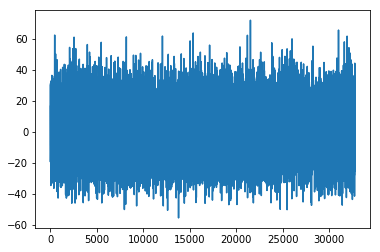

In [129]:
plt.plot(data[4])

In [130]:
#解析にかかった時間を出すため
print("required time : {}".format(time.time() - start_time))

required time : 6899.474713563919


In [131]:
len(data[4])

32767